<a href="https://colab.research.google.com/github/dksifoua/Text-Classification/blob/master/2.%20RNN%20with%20Attention%20Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
!nvidia-smi

Fri Oct 23 18:00:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |   3153MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [132]:
!pip install tqdm --upgrade >> /dev/null 2>&1
!pip install torchtext --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [133]:
import tqdm
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field, LabelField
from torchtext.data.iterator import BucketIterator

In [134]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [135]:
!rm -rf ./data
!mkdir -p ./data
!wget --no-check-certificate \
    https://data.deepai.org/agnews.zip \
    -O ./data/agnews.zip
!unzip -q ./data/agnews.zip -d ./data
!rm -r ./data/agnews.zip

--2020-10-23 18:00:26--  https://data.deepai.org/agnews.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11949309 (11M) [application/x-zip-compressed]
Saving to: ‘./data/agnews.zip’

./data/agnews.zip   100%[===================>]  11.40M  4.74MB/s    in 2.4s    

2020-10-23 18:00:31 (4.74 MB/s) - ‘./data/agnews.zip’ saved [11949309/11949309]



In [136]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print(train.shape, test.shape)
train.head()

(120000, 3) (7600, 3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [137]:
TEXT = Field(lower=True, tokenizer_language='en', tokenize='spacy', include_lengths=True)
LABEL = LabelField(dtype=torch.long)

In [138]:
train_dataset = Dataset([Example.fromdict(data=row.to_dict(), fields={
    'Title': ('title', TEXT),
    'Description': ('desc', TEXT),
    'Class Index': ('trg', LABEL)
}) for _, row in tqdm.tqdm(train.iterrows(), total=len(train))], fields={
    'title': TEXT,
    'desc': TEXT,
    'trg': LABEL
})
test_dataset = Dataset([Example.fromdict(data=row.to_dict(), fields={
    'Title': ('title', TEXT),
    'Description': ('desc', TEXT),
    'Class Index': ('trg', LABEL)
}) for _, row in tqdm.tqdm(test.iterrows(), total=len(test))], fields={
    'title': TEXT,
    'desc': TEXT,
    'trg': LABEL
})
print()
print(f'Length of train dataset: {len(train_dataset.examples):,}')
print(f'Length of test dataset: {len(test_dataset.examples):,}')

100%|██████████| 7600/7600 [00:04<00:00, 1677.72it/s]


Length of train dataset: 120,000
Length of test dataset: 7,600


In [139]:
TEXT.build_vocab(train_dataset, min_freq=2)
LABEL.build_vocab(train_dataset)
print(f'Length of TEXT vocabulary: {len(TEXT.vocab):,}')
print(f'Length of LABEL vocabulary: {len(LABEL.vocab):,}')

Length of TEXT vocabulary: 49,763
Length of LABEL vocabulary: 4


In [140]:
class AttentionRNN(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, n_layers, dropout, pad_index):
        super(AttentionRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        self.pad_index = pad_index
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=True)
        self.W1 = nn.Linear(hidden_size * 2, hidden_size)
        self.W2 = nn.Linear(hidden_size * 2, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def create_mask(self, sequences):
        return sequences != self.pad_index
    
    def attention(self, h_state, outputs, mask):
        """
        :param Tensor[batch_size, hidden_size * 2] h_state
        :param Tensor[seq_len, batch_size, hidden_size * 2] outputs
        :param Tensor[seq_len, batch_size] mask
        :return Tensor[seq_len, batch_size, 1] attention_weights
        """
        h_state = h_state.unsqueeze(0) # [1, batch_size, hidden_size * 2]
        scores = self.V(torch.tanh(self.W1(outputs) + self.W2(h_state))) # [seq_len, batch_size, 1] alignment scores
        mask = mask.unsqueeze(2) # [seq_len, batch_size, 1] Apply mask to ignore <pad> tokens
        scores = scores.masked_fill(mask == 0, 1e-18)
        attention_weights = F.softmax(scores, dim=0) # [seq_len, batch_size, 1]
        return attention_weights

    
    def forward(self, input_sequences, sequence_lengths):
        """
        :param Tensor[seq_len, batch_size] input_sequences
        :param Tensor[batch_size,] sequence_lengths
        :return Tensor[batch_size, output_size] logits
        """
        mask = self.create_mask(input_sequences)
        embedded = self.dropout(self.embedding(input_sequences)) # [seq_len, batch_size, embedding_size]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, h_state = self.gru(packed) 
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # outputs: [seq_len, batch_size, hidden_size * 2]
        # h_state: [n_layers * 2, batch_size, hidden_size]
        h_state = h_state.view(self.n_layers, 2, -1, self.hidden_size) # [n_layers, 2, batch_size, hidden_size]
        h_state = torch.cat([h_state[-1][0], h_state[-1][1]], dim=1) # [batch_size, hidden_size * 2]
        h_state = self.dropout(h_state)
        attention_weights = self.attention(h_state, outputs, mask) # [seq_len, batch_size, 1]
        weighted = torch.bmm(attention_weights.permute(1, 2, 0), outputs.permute(1, 0, 2)) # [batch_size, 1, hidden_size * 2]
        weighted = weighted.squeeze(1) # [batch_size, hidden_size * 2]
        logits = self.fc(weighted) # [batch_size, output_size]
        return logits

In [141]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [142]:
def compute_metrics(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=-1) # [batch_size, 4]
    y_pred = y_pred.argmax(dim=1) # [batch_size,]
    y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return acc, f1

In [143]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
    
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker, acc_tracker, f1_tracker = AverageMeter(), AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            self.optimizer.zero_grad()
            logits = self.model(*batch.desc)
            loss = self.criterion(logits, batch.trg)
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            acc, f1 = compute_metrics(logits, batch.trg)
            loss_tracker.update(loss.item()); acc_tracker.update(acc); f1_tracker.update(f1)
            loss_, acc_, f1_ = loss_tracker.average, acc_tracker.average, f1_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     acc: {acc_*100:.3f}% -     f1: {f1_*100:.3f}%')
        return loss_tracker.average, acc_tracker.average, f1_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, acc_tracker, f1_tracker = AverageMeter(), AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                logits = self.model(*batch.desc)
                loss = self.criterion(logits, batch.trg)
                acc, f1 = compute_metrics(logits, batch.trg)
                loss_tracker.update(loss.item()); acc_tracker.update(acc); f1_tracker.update(f1)
                loss_, acc_, f1_ = loss_tracker.average, acc_tracker.average, f1_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_acc: {acc_*100:.3f}% - val_f1: {f1_*100:.3f}%')
        return loss_tracker.average, acc_tracker.average, f1_tracker.average
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'acc': [], 'loss': [], 'f1': [], 'val_acc': [], 'val_loss': [], 'val_f1': []}, np.inf
        for epoch in range(n_epochs):
            loss, acc, f1 = self.train_step(train_loader, epoch, grad_clip)
            val_loss, val_acc, val_f1 = self.validate(valid_loader, epoch)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './checkpoints/attention-rnn.pth')
            history['acc'].append(acc); history['val_acc'].append(val_acc)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
            history['f1'].append(f1); history['val_f1'].append(val_f1)
        return history

In [144]:
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 256
N_LAYERS = 2
DROPOUT = 0.25
BATCH_SIZE = 64
LR = 5e-4
N_EPOCHS = 5
GRAD_CLIP = 1.0

In [145]:
model = AttentionRNN(vocab_size=len(TEXT.vocab),
                     embedding_size=EMBEDDING_SIZE,
                     hidden_size=HIDDEN_SIZE,
                     output_size=len(np.unique(train['Class Index'])),
                     n_layers=N_LAYERS, dropout=DROPOUT,
                     pad_index=TEXT.vocab.stoi[TEXT.pad_token]).to(DEVICE)
optimizer = optim.RMSprop(params=model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
print(model)
trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion)

Number of parameters of the model: 17,233,673
AttentionRNN(
  (dropout): Dropout(p=0.25, inplace=False)
  (embedding): Embedding(49763, 300)
  (gru): GRU(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  (W1): Linear(in_features=512, out_features=256, bias=True)
  (W2): Linear(in_features=512, out_features=256, bias=True)
  (V): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)


In [146]:
train_iterator, test_iterator =  BucketIterator.splits((train_dataset, test_dataset),
                                                       batch_size=BATCH_SIZE,
                                                       sort_key=lambda x: len(x.desc),
                                                       sort_within_batch=True,
                                                       device=DEVICE)
!mkdir -p ./checkpoints
history = trainer.train(train_loader=train_iterator, valid_loader=test_iterator, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 0.453 -     acc: 83.388% -     f1: 83.335%: 100%|██████████| 1875/1875 [00:46<00:00, 40.08it/s]
Epoch: 01 - val_loss: 0.319 - val_acc: 89.089% - val_f1: 89.078%: 100%|██████████| 119/119 [00:01<00:00, 113.78it/s]
Epoch: 02 -     loss: 0.275 -     acc: 90.312% -     f1: 90.317%: 100%|██████████| 1875/1875 [00:46<00:00, 40.30it/s]
Epoch: 02 - val_loss: 0.269 - val_acc: 90.857% - val_f1: 90.862%: 100%|██████████| 119/119 [00:01<00:00, 118.35it/s]
Epoch: 03 -     loss: 0.217 -     acc: 92.397% -     f1: 92.407%: 100%|██████████| 1875/1875 [00:46<00:00, 40.64it/s]
Epoch: 03 - val_loss: 0.253 - val_acc: 91.575% - val_f1: 91.591%: 100%|██████████| 119/119 [00:01<00:00, 117.49it/s]
Epoch: 04 -     loss: 0.178 -     acc: 93.757% -     f1: 93.760%: 100%|██████████| 1875/1875 [00:46<00:00, 40.63it/s]
Epoch: 04 - val_loss: 0.267 - val_acc: 91.601% - val_f1: 91.643%: 100%|██████████| 119/119 [00:01<00:00, 117.75it/s]
Epoch: 05 -     loss: 0.148 -     acc: 94.805% -     f1: 94.

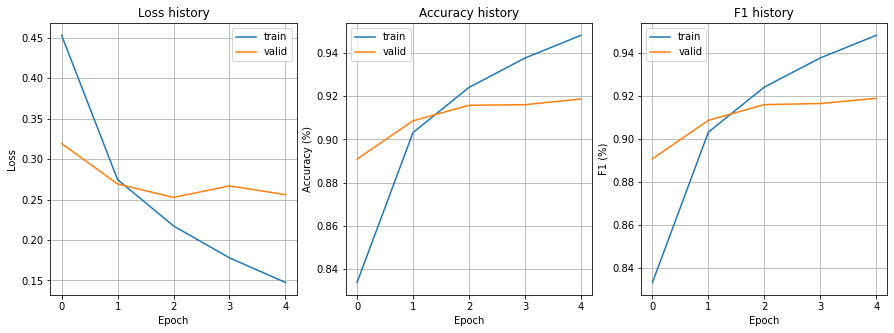

In [147]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['acc'], label='train')
axes[1].plot(history['val_acc'], label='valid')
axes[1].set_title('Accuracy history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['f1'], label='train')
axes[2].plot(history['val_f1'], label='valid')
axes[2].set_title('F1 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

In [148]:
model.load_state_dict(torch.load('./checkpoints/attention-rnn.pth'))
model.to(DEVICE)

AttentionRNN(
  (dropout): Dropout(p=0.25, inplace=False)
  (embedding): Embedding(49763, 300)
  (gru): GRU(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  (W1): Linear(in_features=512, out_features=256, bias=True)
  (W2): Linear(in_features=512, out_features=256, bias=True)
  (V): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [149]:
_, val_acc, val_f1 = trainer.validate(test_iterator, 0)

Epoch: 01 - val_loss: 0.253 - val_acc: 91.575% - val_f1: 91.591%: 100%|██████████| 119/119 [00:01<00:00, 113.83it/s]


In [150]:
print(f'Accuracy score: {val_acc*100:.3f}% - F1 score: {val_f1*100:.3f}%')

Accuracy score: 91.575% - F1 score: 91.591%
